In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

import os
import random
from collections import defaultdict
from PIL import Image
from torch.utils.data import DataLoader, Dataset

from loguru import logger
random.seed(0) #for reproducibility

In [ ]:
class Market1501(Dataset):
    def __init__(self, root="../../data/Market-1501/", train=True,
                 transform=None, target_transform=None):
        """Treats the test and query folders as training and the train folder as test."""
        self.are_we_training = train
        self.root = root
        self.label_to_start_stop_idxs = defaultdict(list)
       # self.idx_to_label = defaultdict(lambda : -1)
        #self.labels_to_idxs = defaultdict(list)
        self.labels = []
        self.idx_to_label = {}
        
        self.transform = transform
        self.target_transform = target_transform
        
        #NOTE TEST, TRAIN here are not the same as our val/train.
        self._TEST_FOLDER = os.path.join(self.root, "bounding_box_test")
        self._QUERY_FOLDER = os.path.join(self.root, "query")
        self._TRAIN_FOLDER = os.path.join(self.root, "bounding_box_train")
        
        if self.are_we_training:
            
            self.filenames = []
            #self.curr_idx = 0
            test_box_filenames = os.listdir(self._TEST_FOLDER)
            query_filenames = os.listdir(self._QUERY_FOLDER)
            
            
            #ignore junk/distraction files
            test_box_filenames = test_box_filenames[6617:] 
            
            #ignore thumbs.db
            test_box_filenames = test_box_filenames[:-1]
            query_filenames = query_filenames[:-1]
            
            self.label_to_filenames = defaultdict(list) #label -> list of filenames
            
            #we have label_to_filename[label] = [filename, filename, ...]
            latest_label_seen = -1
            
            #we want to have all the elements with the same label occur together
            #so we fiddle around a bit to make that happen
            for filename in test_box_filenames:
                full_filename = os.path.join(self._TEST_FOLDER, filename)
                label = int(filename[:4])
                self.label_to_filenames[label].append(full_filename)
                if label > latest_label_seen: #new label
                    self.labels.append(label)
                    latest_label_seen = label
                
            for filename in query_filenames:
                full_filename = os.path.join(self._QUERY_FOLDER, filename)
                label = int(filename[:4])
                self.label_to_filenames[label].append(full_filename)
                
            idx = 0
            for label in self.labels:
                start_idx = idx 
                for filename in self.label_to_filenames[label]:
                    self.filenames.append(filename)
                    self.idx_to_label[idx] = label
                    idx += 1
                end_idx = idx - 1
                self.label_to_start_stop_idxs[label] = [start_idx, end_idx]
            
        else:
            self.filenames = []
            
            #ignore thumbs.db
            train_filenames = os.listdir(self._TRAIN_FOLDER)[:-1]
            
            latest_label_seen = 2
            self.label_to_start_stop_idxs[latest_label_seen].append(0)
            self.labels = [2]
            for i,filename in enumerate(train_filenames):
                full_filename = os.path.join(self._TRAIN_FOLDER, filename)
                self.filenames.append(full_filename)
                label = int(filename[:4])
                self.idx_to_label[i] = label
                if label > latest_label_seen:
                    self.label_to_start_stop_idxs[latest_label_seen].append(i-1)
                    latest_label_seen = label
                    self.label_to_start_stop_idxs[label] = [i]
                    self.labels.append(label)
            #boundary case: the last label won't have an end point
            self.label_to_start_stop_idxs[latest_label_seen].append(len(train_filenames) - 1)
            
        #self.labels_inv[self.labels[i]] = i
        self.labels_inv = {x : i for (i,x) in enumerate(self.labels)}
                    
    
    def __getitem__(self, idx):
        #we will get the image from self.filenames[i]
        img = Image.open(self.filenames[idx]).convert("RGB")
        
        #use labels_inv to get labels between 0 and N-1
        #instead of 1, 4, 7, ...
        label = self.labels_inv[self.idx_to_label[idx]]
        
        if self.transform is not None:
            img = self.transform(img)
            
        if self.target_transform is not None:
            label = self.target_transform(label)
        
        return img, label
    
    def __len__(self):
        return len(self.filenames)
        

In [ ]:
root = "../../data/Market-1501/"

In [ ]:
TEST_FOLDER_PATH = os.path.join(root, "bounding_box_test")
QUERY_FOLDER_PATH = os.path.join(root, "query")
TRAIN_FOLDER_PATH = os.path.join(root, "bounding_box_train")

In [ ]:
l = os.listdir(TEST_FOLDER_PATH)
m = os.listdir(QUERY_FOLDER_PATH)
n = os.listdir(TRAIN_FOLDER_PATH)

In [ ]:
len(l), len(m), len(n)

In [ ]:
l[6616], l[6617]

In [ ]:
query_plus_test = 19733 - 6617 + 3369
query_plus_test #since more query + test than number of training, we use it as train instead

In [ ]:
l[-2], m[-2]

#### **Testing Dataset**

In [ ]:
dataset = Market1501(train=True)

In [ ]:
img, label = dataset[0]
print(f"label = {label}\n\n")
print(f"type(img) = {type(img)}")
#print(f"img has shape {img.shape}\n\n")


plt.imshow(img)
plt.show()

In [ ]:
len(dataset)

In [ ]:
dataset.label_to_start_stop_idxs[3]

In [ ]:
[dataset.idx_to_label[i] for i in range(65, 80)]

In [ ]:
dataset.idx_to_label[79]

In [ ]:
test_dataset = Market1501(train=False)
img, label = test_dataset[0]
print(f"label = {label}\n\n")
print(f"type(img) = {type(img)}")
#print(f"img has shape {img.shape}\n\n")


plt.imshow(img)
plt.show()

In [ ]:
test_dataset.label_to_start_stop_idxs[test_dataset.labels[0]]

In [ ]:
[test_dataset.idx_to_label[i] for i in range(0,46)]

In [ ]:
import sys

sys.path.insert(0, "../../")

In [ ]:
P = 4 #4 classes, each with 3 samples
K = 3

In [ ]:
labels = dataset.labels
start_indices = {i : dataset.label_to_start_stop_idxs[label][0] 
                 for i,label in enumerate(labels)}
num_examples = {i : 
                (dataset.label_to_start_stop_idxs[label][1] - \
                dataset.label_to_start_stop_idxs[label][0] + 1)
                for i, label in enumerate(labels)}
num_classes = len(labels)

In [22]:
labels[:5]

[1, 3, 4, 5, 6]

In [23]:
start_indices[1], start_indices[1] + num_examples[1] - 1

(65, 79)

In [24]:
import sys
sys.path.insert(0,'../')
import data_tools.UniformSampler as US



In [25]:
P=4
K=4

In [33]:
dataset = Market1501(train=True, transform=T.ToTensor())

In [34]:

uniform_sampler = US.ClassUniformBatchSampler(dataset, P=P, K=K, start_indices=start_indices,
                                              num_examples=num_examples, num_classes=num_classes,
                                              k_at_time=US._get_k_at_time(start_indices, 
                                                                          num_examples, 
                                                                          K,
                                                                          num_classes=num_classes),
                                              logger=logger) #renaming for convenience

2022-11-20 11:02:58.459 | INFO     | data_tools.UniformSampler:__init__:50 - initialization of sampler complete.


In [35]:
from mpl_toolkits.axes_grid1 import ImageGrid

In [36]:
def display_batch(batch, P=P, K=K, convert_tensor=True):
    """Displays the batch as a PxK grid of images."""
    fig = plt.figure(figsize=(20,20))
    grid = ImageGrid(fig, 111, nrows_ncols=(K, P), axes_pad=0.1)
    
    
    for ax, (im_tensor,_) in zip(grid, batch):
        if convert_tensor:
            im_to_print = im_tensor.to("cpu").numpy()
            #put channel dimension at the end
            im_to_print = np.transpose(im_to_print, (1,2,0))
        else:
            im_to_print = im_tensor
       
        ax.imshow(im_to_print)

    plt.show()        

2022-11-20 11:02:59.017 | INFO     | data_tools.UniformSampler:__iter__:58 - __iter__ called
2022-11-20 11:02:59.017 | INFO     | data_tools.UniformSampler:__iter__:70 - In step 1: ---------------------------
2022-11-20 11:02:59.018 | INFO     | data_tools.UniformSampler:__iter__:81 - indexes selected
2022-11-20 11:02:59.018 | INFO     | data_tools.UniformSampler:__iter__:85 - yielding batch 1


im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>
im_to_print has type: <class 'numpy.ndarray'>


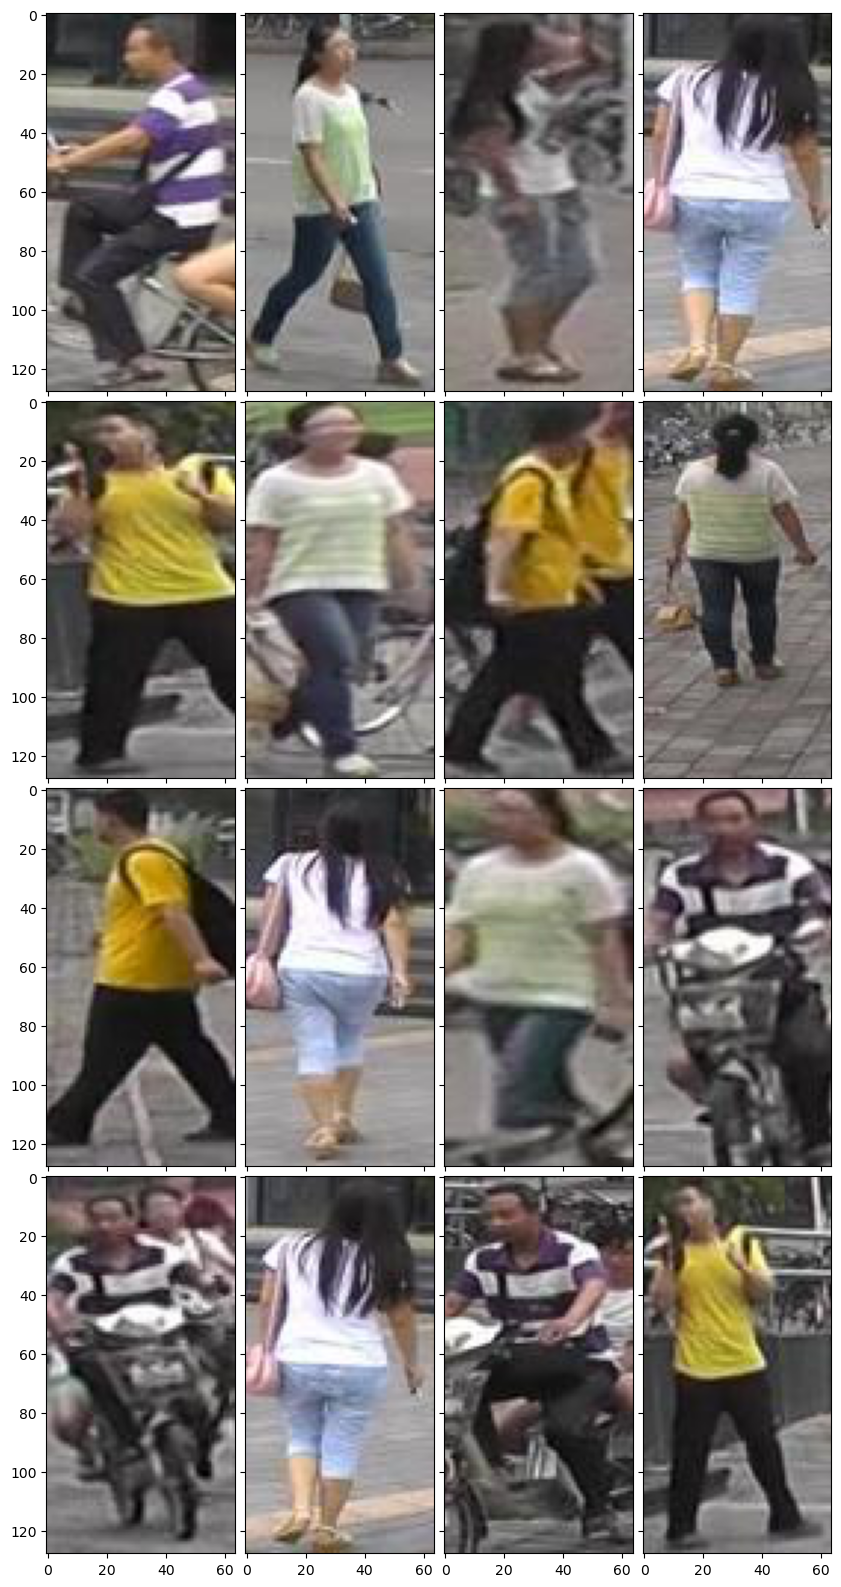

In [37]:
iter_sampler = iter(uniform_sampler)
images = [dataset[i] for i in next(iter_sampler)]
display_batch(images, convert_tensor=True)

In [38]:
train_loader = torch.utils.data.DataLoader(dataset, batch_sampler=uniform_sampler, num_workers=16)

In [39]:
dataloader_iterator = iter(train_loader)